Understanding interpolation methods in image registration.  
1. Shows the weights on the surrounding pixels in each common interpolation type.  
2. Show an example of the difference on a toy image.

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp
from skimage import io, transform
from skimage.transform import resize

# Interpolation Types Surrounding Pixel Weights

In [12]:
# Bilinear kernel function (for nearest neighbors)
def linear_kernel(t):
    return 1 - np.abs(t)

# Cubic kernel function
def cubic_kernel(t):
    t = np.abs(t)
    if t <= 1:
        return 1.5 * t**3 - 2.5 * t**2 + 1
    elif t <= 2:
        return -0.5 * t**3 + 2.5 * t**2 - 4 * t + 2
    else:
        return 0

# Nearest neighbor weight calculation
def nearest_neighbor_weights(point_x, point_y, grid_x, grid_y):
    weights = np.zeros((4, 4))
    nearest_x = int(round(point_x))
    nearest_y = int(round(point_y))
    weights[nearest_x, nearest_y] = 1
    return weights

In [13]:
# Bilinear weight calculation (only 4 nearest neighbors)
def bilinear_weights(point_x, point_y, grid_x, grid_y):
    weights = np.zeros((4, 4))
    
    # Find the closest 4 grid points surrounding the random point
    x0, x1 = int(np.floor(point_x)), int(np.ceil(point_x))
    y0, y1 = int(np.floor(point_y)), int(np.ceil(point_y))

    # Calculate the weights for the 4 surrounding pixels
    for i in [x0, x1]:
        for j in [y0, y1]:
            weight_x = linear_kernel(point_x - i)
            weight_y = linear_kernel(point_y - j)
            weights[i, j] = weight_x * weight_y
    
    # Normalize the weights so they sum to 1
    total_weight = np.sum(weights)
    if total_weight > 0:
        weights /= total_weight

    return weights

# Bicubic weight calculation
def bicubic_weights(point_x, point_y, grid_x, grid_y):
    weights = np.zeros((4, 4))
    total_weight = 0
    for i in range(4):
        for j in range(4):
            weight_x = cubic_kernel(point_x - grid_x[i, j])
            weight_y = cubic_kernel(point_y - grid_y[i, j])
            weights[i, j] = weight_x * weight_y
            total_weight += weights[i, j]
    
    if total_weight > 0:
        weights /= total_weight  # Normalize to sum to 1
    return weights

In [14]:
# Function to plot a 4x4 grid with weights
def plot_interpolation(ax, method_name, weights, point_x, point_y):
    cmap = plt.get_cmap('viridis')
    
    # Plot the weights
    for i in range(4):
        for j in range(4):
            ax.add_patch(plt.Rectangle((i - 0.5, j - 0.5), 1, 1, color=cmap(weights[i, j])))
            ax.text(i, j, f'{weights[i, j]:.2f}', ha='center', va='center', color='white')

    # Highlight the interpolated point
    ax.scatter(point_x, point_y, color='red', label='Interpolated Point', s=100, edgecolor='black')
    
    # Customize plot
    ax.set_xticks(np.arange(0, 4))
    ax.set_yticks(np.arange(0, 4))
    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(-0.5, 3.5)
    ax.set_title(f'{method_name} Interpolation', size=18)
    ax.legend()

In [15]:
# Main function to perform nearest neighbor, bilinear, and bicubic interpolation
def interpolate_and_plot():
    # Generate a random point within the central area
    point_x, point_y = np.random.uniform(1, 2), np.random.uniform(1, 2)
    
    # Generate a 4x4 grid of points
    grid_x, grid_y = np.mgrid[0:4, 0:4]

    # Compute the weights for each interpolation method
    nearest_weights = nearest_neighbor_weights(point_x, point_y, grid_x, grid_y)
    bilinear_weights_ = bilinear_weights(point_x, point_y, grid_x, grid_y)
    bicubic_weights_ = bicubic_weights(point_x, point_y, grid_x, grid_y)

    # Create subplots for the different interpolation methods
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Weights of Surrounding Pixels in Interpolation', fontsize=22)

    # Plot Nearest Neighbor interpolation weights
    plot_interpolation(axes[0], 'Nearest Neighbor', nearest_weights, point_x, point_y)
    
    # Plot Bilinear interpolation weights
    plot_interpolation(axes[1], 'Bilinear', bilinear_weights_, point_x, point_y)
    
    # Plot Bicubic interpolation weights
    plot_interpolation(axes[2], 'Bicubic', bicubic_weights_, point_x, point_y)

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    #plt.savefig('../static/img/interpolation_weights.png', bbox_inches='tight')
    plt.show()


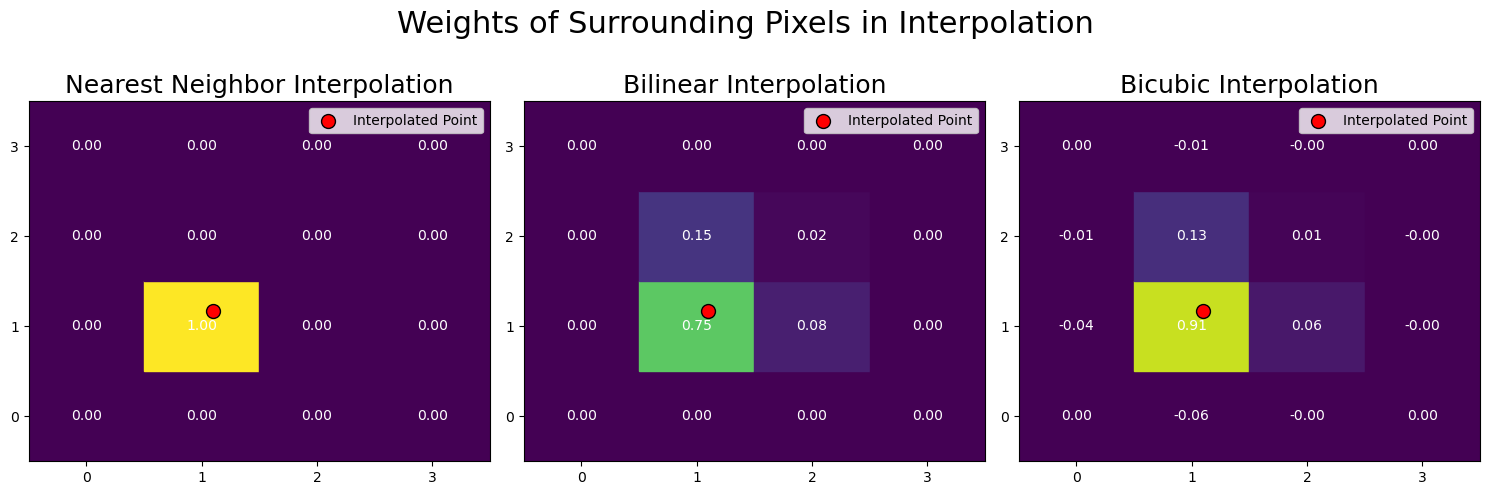

In [17]:
interpolate_and_plot()

# Show Example:

## Create Source Image:

In [7]:
def create_alternating_color_grid(size=50, pixel_interval_x=1, pixel_interval_y=1, color1=(255, 0, 0), color2=(0, 0, 255), color3=None):
    """
    Create an image where pixels alternate colors every `pixel_interval_x` and `pixel_interval_y` pixels.
    If `color3` is provided, the grid will alternate between three colors. Otherwise, it alternates between two colors.
    """
    img = np.zeros((size, size, 3), dtype=np.uint8)
    
    # Set alternating colors based on x and y pixel intervals
    for i in range(size):
        for j in range(size):
            if color3 is None:
                # Alternate between two colors
                if ((i // pixel_interval_y) + (j // pixel_interval_x)) % 2 == 0:
                    img[i, j] = color1  # First color
                else:
                    img[i, j] = color2  # Second color
            else:
                # Alternate between three colors
                color_choice = ((i // pixel_interval_y) + (j // pixel_interval_x)) % 3
                if color_choice == 0:
                    img[i, j] = color1  # First color
                elif color_choice == 1:
                    img[i, j] = color2  # Second color
                else:
                    img[i, j] = color3  # Third color

    return img

## Transform image:

In [8]:
def shear_image(image, shear_factor, interpolation):
    """Apply shear to the image using the specified interpolation with black margins."""
    tform = AffineTransform(shear=np.deg2rad(shear_factor))
    # Set mode to 'constant' and cval=0 to see black margins
    return warp(image, tform, mode='constant', cval=0, order=interpolation)


def rotate_image(image, angle, interpolation):
    """Apply rotation to the image using the specified interpolation."""
    size = image.shape[0]
    center = (size // 2, size // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (size, size), flags=interpolation)

## Run Transformations and Plot

In [9]:
def plot_source_and_transformed(original, transformed_images, interpolation_labels, title, filename=None):
    
    fig, axs = plt.subplots(1, len(transformed_images) + 1, figsize=(16, 4))

    # Plot source image
    axs[0].imshow(original)
    axs[0].set_title("Source Image")
    axs[0].axis('off')

    # Plot transformed images
    for i, (transformed, label) in enumerate(zip(transformed_images, interpolation_labels)):
        axs[i + 1].imshow(transformed)
        axs[i + 1].set_title(f'{label} Interpolation')
        axs[i + 1].axis('off')

    fig.suptitle(title, fontsize=22)

    plt.savefig(filename, bbox_inches='tight')

    plt.show()


def run_transformations(image, shear_factor, rotation_angle, interpolation_labels):
    
    # Apply shearing with different interpolations
    nearest_shear = shear_image(image, shear_factor, interpolation=0)  # Nearest neighbor
    linear_shear = shear_image(image, shear_factor, interpolation=1)  # Bilinear
    cubic_shear = shear_image(image, shear_factor, interpolation=3)  # Bicubic

    # Apply rotation with different interpolations
    nearest_rotate = rotate_image(image, rotation_angle, interpolation=cv2.INTER_NEAREST)
    linear_rotate = rotate_image(image, rotation_angle, interpolation=cv2.INTER_LINEAR)
    cubic_rotate = rotate_image(image, rotation_angle, interpolation=cv2.INTER_CUBIC)

    # Combine the transformed images and labels for shearing and rotation
    shear_transformed_images = [nearest_shear, linear_shear, cubic_shear]
    rotate_transformed_images = [nearest_rotate, linear_rotate, cubic_rotate]

    # Plot and save the source and sheared images
    plot_source_and_transformed(
        image, shear_transformed_images, interpolation_labels,
        title='Shearing with Different Interpolations',
        filename=f'../static/img/interpolation_shearing.png'
    )

    # Plot and save the source and rotated images
    plot_source_and_transformed(
        image, rotate_transformed_images, interpolation_labels,
        title='Rotation with Different Interpolations',
        filename=f'../static/img/interpolation_rotation.png'
    )


### Set parameters:

In [10]:
# Customize your parameters here
pixel_interval_x = 3  # Change colors every `x` pixels along the x-axis
pixel_interval_y = 1  # Change colors every `y` pixels along the y-axis
color1 = (255, 0, 0)  # Red
color2 = (0, 0, 255)  # Blue
color3 = (0, 255, 0) # Green - optional
shear_factor = 25  # Shear angle in degrees
rotation_angle = 30  # Rotation angle in degrees
interpolation_labels = ['Nearest', 'Linear', 'Cubic']

### Run:

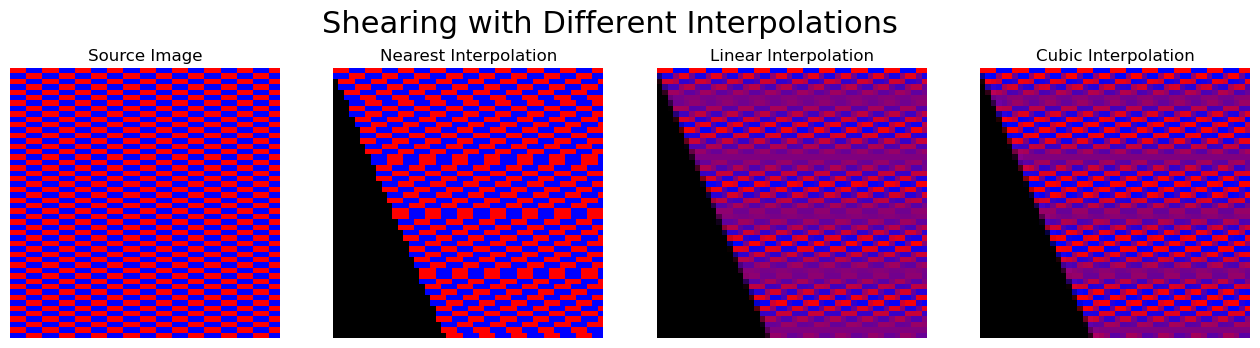

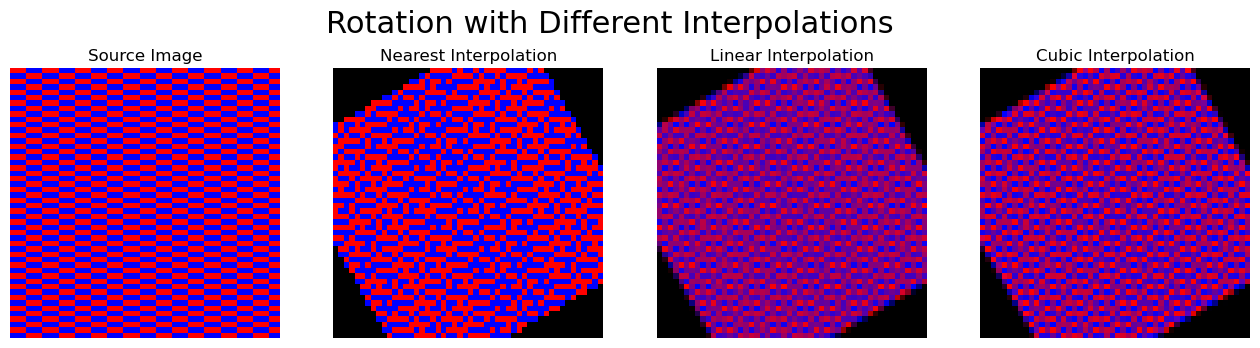

In [11]:
# Create an image with alternating colors and pixel intervals
image = create_alternating_color_grid(size=50, pixel_interval_x=pixel_interval_x, pixel_interval_y=pixel_interval_y, color1=color1, color2=color2)

# Run the transformations and save plots
run_transformations(image, shear_factor, rotation_angle, interpolation_labels)


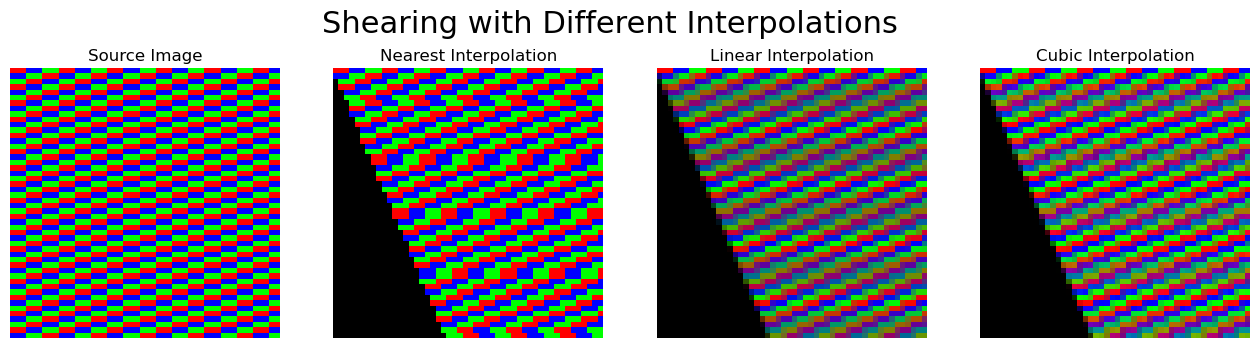

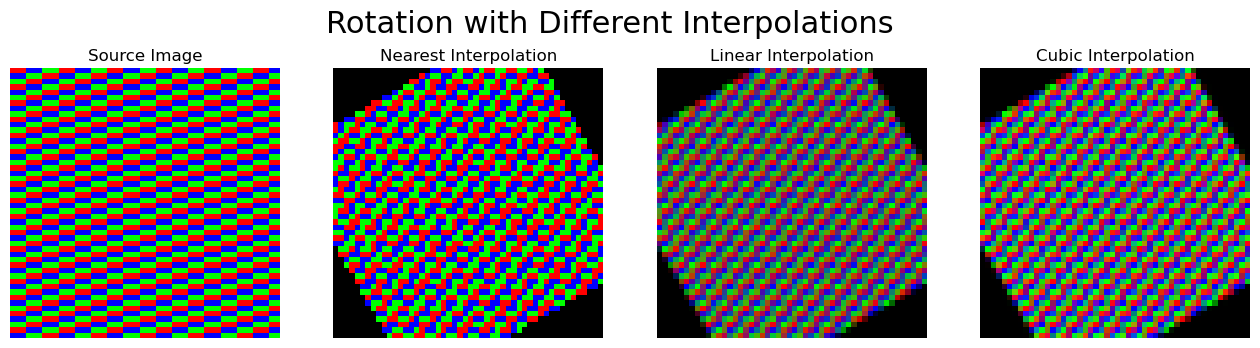

In [12]:
# Create an image with alternating colors and pixel intervals
image = create_alternating_color_grid(size=50, pixel_interval_x=pixel_interval_x, pixel_interval_y=pixel_interval_y, color1=color1, color2=color2, color3=color3)

# Run the transformations and save plots
run_transformations(image, shear_factor, rotation_angle, interpolation_labels)


# Anti-Aliasing when Downsampling
Is a common practice to avoid pixelation.  
It's practically applying a gaussian filter on the image to smoothen it before downsampling the image.

In [13]:
def load_image(file_path):
    return io.imread(file_path)


In [14]:
def downsample_image(image, scale_factor, anti_aliasing=True):
    new_shape = tuple(int(s * scale_factor) for s in image.shape[:2]) + image.shape[2:]
    return resize(image, new_shape, anti_aliasing=anti_aliasing)

In [15]:
def plot_comparison(original, downsampled_aa, downsampled_no_aa, scale_factor):
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))

    title_size = 15
    
    axs[0].imshow(original)
    axs[0].set_title('Original Image', size=title_size)
    axs[0].axis('off')
    
    axs[1].imshow(downsampled_aa)
    axs[1].set_title(f'Downsampled (1/{int(1/scale_factor)}) with Anti-Aliasing', size=title_size)
    axs[1].axis('off')
    
    axs[2].imshow(downsampled_no_aa)
    axs[2].set_title(f'Downsampled (1/{int(1/scale_factor)}) without Anti-Aliasing', size=title_size)
    axs[2].axis('off')

    plt.savefig('../static/img/antialias.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

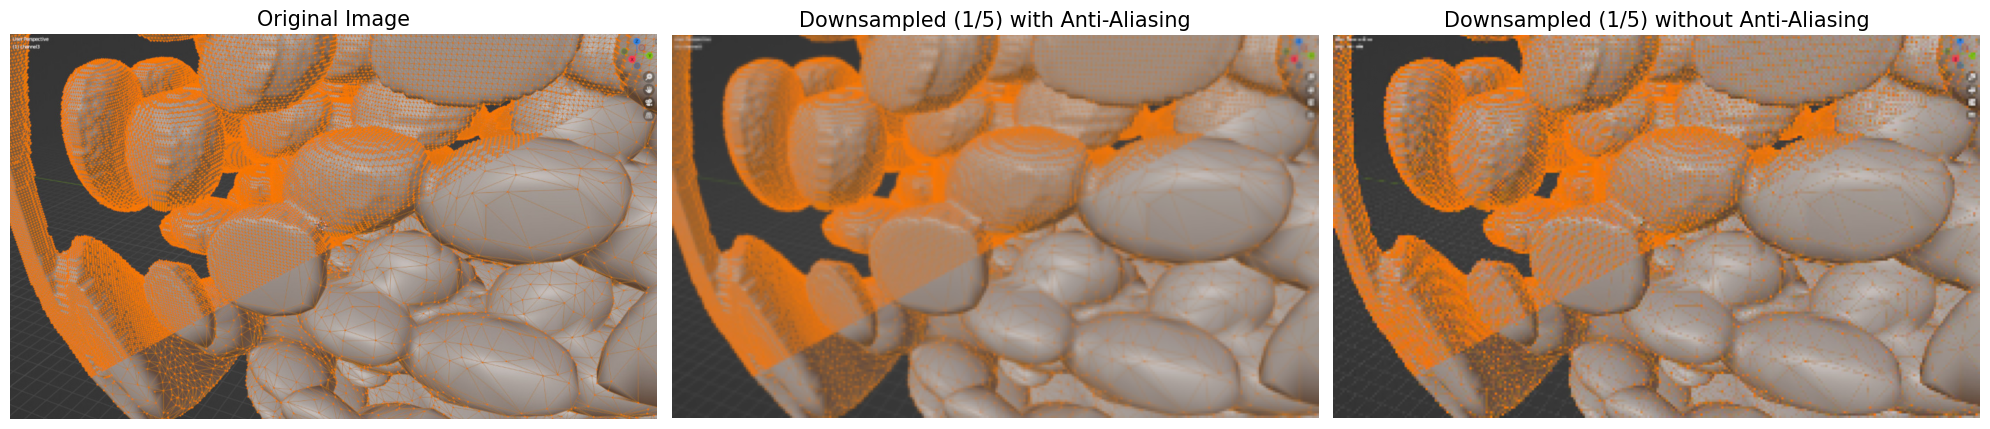

In [16]:
image_path = '../static/img/reducing-mesh-complexity.jpg'  # Replace with your image path

# Set the scale factor for downsampling
scale_factor = 0.2  

original_image = load_image(image_path)

# Downsample with anti-aliasing
downsampled_aa = downsample_image(original_image, scale_factor, anti_aliasing=True)

# Downsample without anti-aliasing
downsampled_no_aa = downsample_image(original_image, scale_factor, anti_aliasing=False)

# Plot the results
plot_comparison(original_image, downsampled_aa, downsampled_no_aa, scale_factor)


## Interpolation grid:

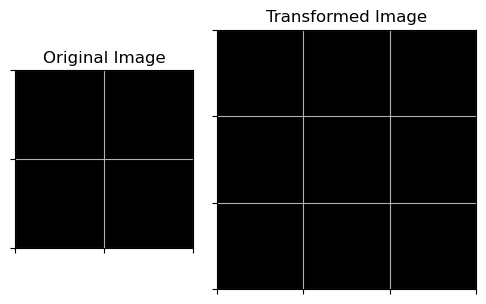

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Define the size of each cell (e.g., 1 inch per cell)
cell_size = 1  # Adjust as needed

# Define grid sizes
grid_2x2 = np.zeros((2, 2))
grid_3x3 = np.zeros((3, 3))

# Create figure with enough width to accommodate both grids while maintaining cell size
fig = plt.figure(figsize=(cell_size * 5, cell_size * 3))

# Set up GridSpec with correct width_ratios to keep cells the same size
gs = GridSpec(1, 2, width_ratios=[2, 3], height_ratios=[1])

# Plot the 2x2 grid
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(grid_2x2, cmap='gray', interpolation='none')
ax1.set_title('Original Image')
ax1.set_xticks(np.arange(-0.5, 2, 1))
ax1.set_yticks(np.arange(-0.5, 2, 1))
ax1.grid(True)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_aspect('equal')  # Ensure square cells

# Plot the 3x3 grid
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(grid_3x3, cmap='gray', interpolation='none')
ax2.set_title('Transformed Image')
ax2.set_xticks(np.arange(-0.5, 3, 1))
ax2.set_yticks(np.arange(-0.5, 3, 1))
ax2.grid(True)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_aspect('equal')  # Ensure square cells

# Adjust layout
plt.tight_layout()
plt.savefig('../static/img/grids.png')
plt.show()
